In [1]:
import pickle
import numpy as np
import scvelo as scv
import scanpy
import torch

from veloproj import *

scv.settings.verbosity = 1

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-6',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--data-dir', '/data/users/cqiao/notebooks/projects/PaperRev/VeloRep2/endocrinogenesis_day15.5.h5ad',
                               '--model-name', 'pancreas_model.cpt',
                               '--exp-name', 'CohAE_pancreas',
                               '--device', 'cuda:2',
                               '--gumbsoft_tau', '1',
                               '--nb_g_src', 'SU',
                               '--ld_nb_g_src', "X",
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'true',
                               '--use_offset_pred', 'false',
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_umap',
                               '--vis_type_col', 'clusters',
                               '--scv_n_jobs', '10',
                              ])
args                              

Namespace(adata=None, aux_weight=1.0, conv_thred=1e-06, data_dir='/data/users/cqiao/notebooks/projects/PaperRev/VeloRep2/endocrinogenesis_day15.5.h5ad', device='cuda:2', exp_name='CohAE_pancreas', fit_offset_pred=True, fit_offset_train=False, g_rep_dim=100, gnn_layer='GAT', gumbsoft_tau=1.0, h_dim=256, k_dim=100, ld_adata='projection.h5', ld_nb_g_src='X', log_interval=100, lr=1e-06, lr_decay=0.9, mask_cluster_list=None, model_name='pancreas_model.cpt', n_conn_nb=30, n_epochs=20000, n_nb_newadata=30, n_raw_gene=2000, nb_g_src='SU', output='./', refit=True, scv_n_jobs=10, seed=42, sl1_beta=1.0, use_norm=False, use_offset_pred=False, use_x=False, v_rg_wt=0.0, vis_key='X_umap', vis_type_col='clusters', weight_decay=0.0, z_dim=100)

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [
    ("Ngn3 low EP", "Ngn3 high EP"), 
    ("Ngn3 high EP", "Fev+"), 
    ("Fev+", "Alpha"), 
    ("Fev+", "Beta"), 
    ("Fev+", "Delta"), 
    ("Fev+", "Epsilon")]
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [6]:
adata = scanpy.read_h5ad(args.data_dir)
scv.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.81 0.19]
AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'connectivities', 'distances'


or disable the progress bar using `show_progress_bar=False`.


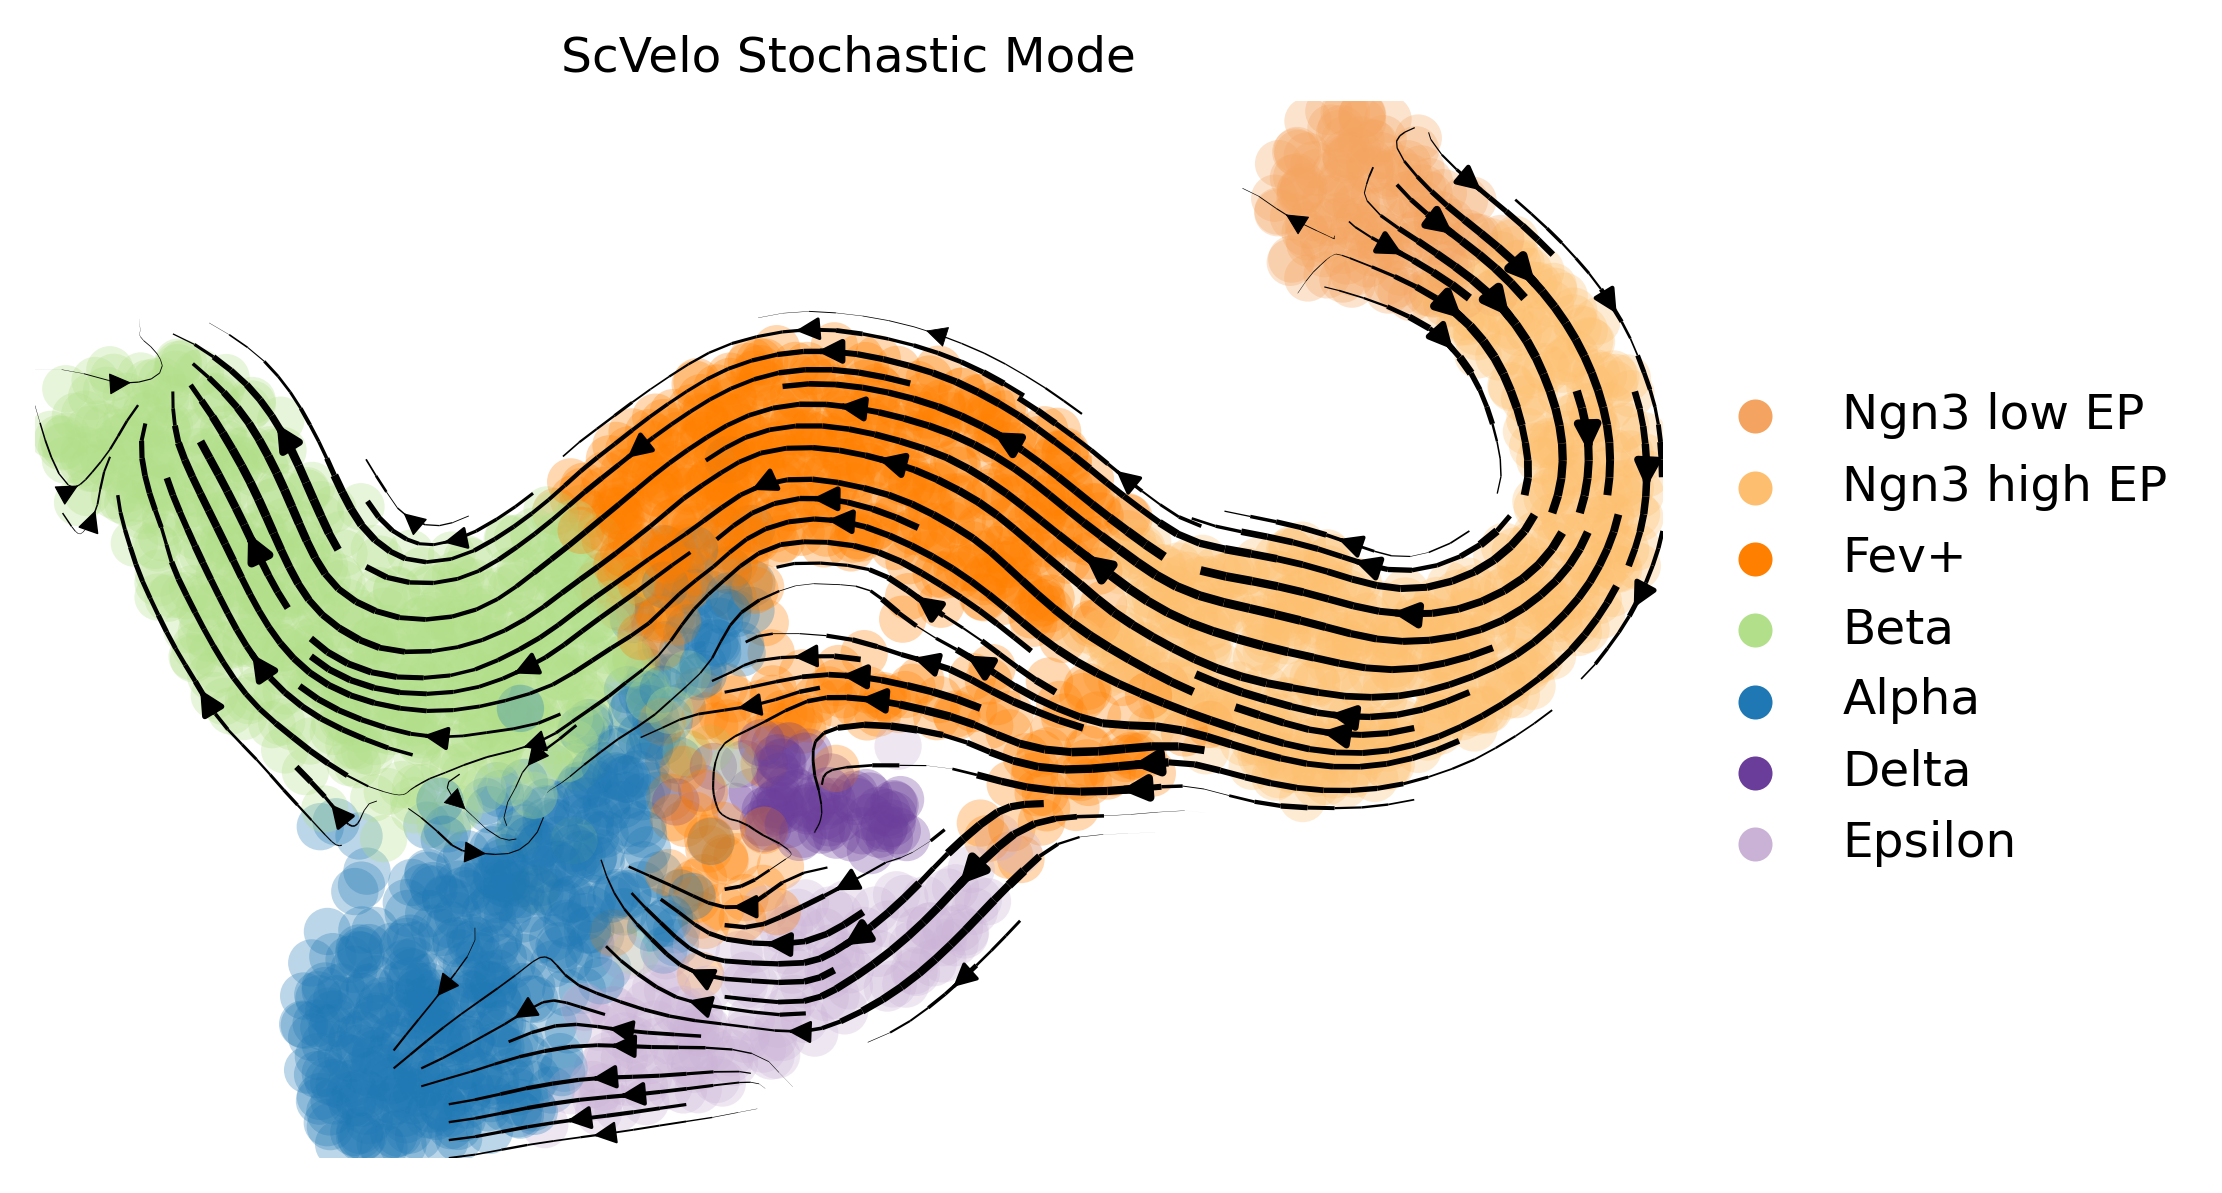

# Cross-Boundary Transition Score (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.15623179, ('Ngn3 high EP', 'Fev+'): 0.23484711, ('Fev+', 'Alpha'): 0.19807772, ('Fev+', 'Beta'): 0.24194431, ('Fev+', 'Delta'): 0.19956158, ('Fev+', 'Epsilon'): 0.10291402}
Total Mean: 0.18892942368984222
# Cross-Boundary Velocity Coherence (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.97805756, ('Ngn3 high EP', 'Fev+'): 0.8823927, ('Fev+', 'Alpha'): 0.71744776, ('Fev+', 'Beta'): 0.6556835, ('Fev+', 'Delta'): 0.79728156, ('Fev+', 'Epsilon'): 0.8656598}
Total Mean: 0.8160871863365173
# Cross-Boundary Direction Correctness (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.8427982226394763, ('Ngn3 high EP', 'Fev+'): 0.6803993580134802, ('Fev+', 'Alpha'): 0.46051810742512633, ('Fev+', 'Beta'): 0.7558329811317434, ('Fev+', 'Delta'): 0.11593185183296813, ('Fev+', 'Epsilon'): 0.01687290169074372}
Total Mean: 0.47872557045558967
# In-cluster Coherence
{'Alpha': 0.72817194, 'Beta': 0.74304336, 'Delta': 0.776115, 'Epsilon': 0.855

In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  legend_loc="right margin", vkey="stc_velocity", basis=args.vis_key, color=args.vis_type_col,
                                 dpi=350, 
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, args.vis_type_col, "stc_velocity")

Train Epoch: 100/20000 	Loss: 33.660179
Train Epoch: 200/20000 	Loss: 33.444675
Train Epoch: 300/20000 	Loss: 33.220013
Train Epoch: 400/20000 	Loss: 32.869541
Train Epoch: 500/20000 	Loss: 32.445778
Train Epoch: 600/20000 	Loss: 32.091694
Train Epoch: 700/20000 	Loss: 31.747828
Train Epoch: 800/20000 	Loss: 31.388170
Train Epoch: 900/20000 	Loss: 31.073837
Train Epoch: 1000/20000 	Loss: 30.745310
Train Epoch: 1100/20000 	Loss: 30.441328
Train Epoch: 1200/20000 	Loss: 30.107819
Train Epoch: 1300/20000 	Loss: 29.743294
Train Epoch: 1400/20000 	Loss: 29.378172
Train Epoch: 1500/20000 	Loss: 29.015997
Train Epoch: 1600/20000 	Loss: 28.651711
Train Epoch: 1700/20000 	Loss: 28.322575
Train Epoch: 1800/20000 	Loss: 28.015852
Train Epoch: 1900/20000 	Loss: 27.675350
Train Epoch: 2000/20000 	Loss: 27.391903
Train Epoch: 2100/20000 	Loss: 27.159142
Train Epoch: 2200/20000 	Loss: 26.920351
Train Epoch: 2300/20000 	Loss: 26.632235
Train Epoch: 2400/20000 	Loss: 26.264763
Train Epoch: 2500/20000 	

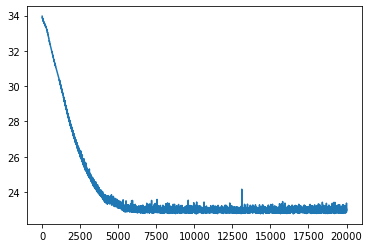

In [8]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

saving figure to file ./figures/scvelo_pancreas_pojection.png


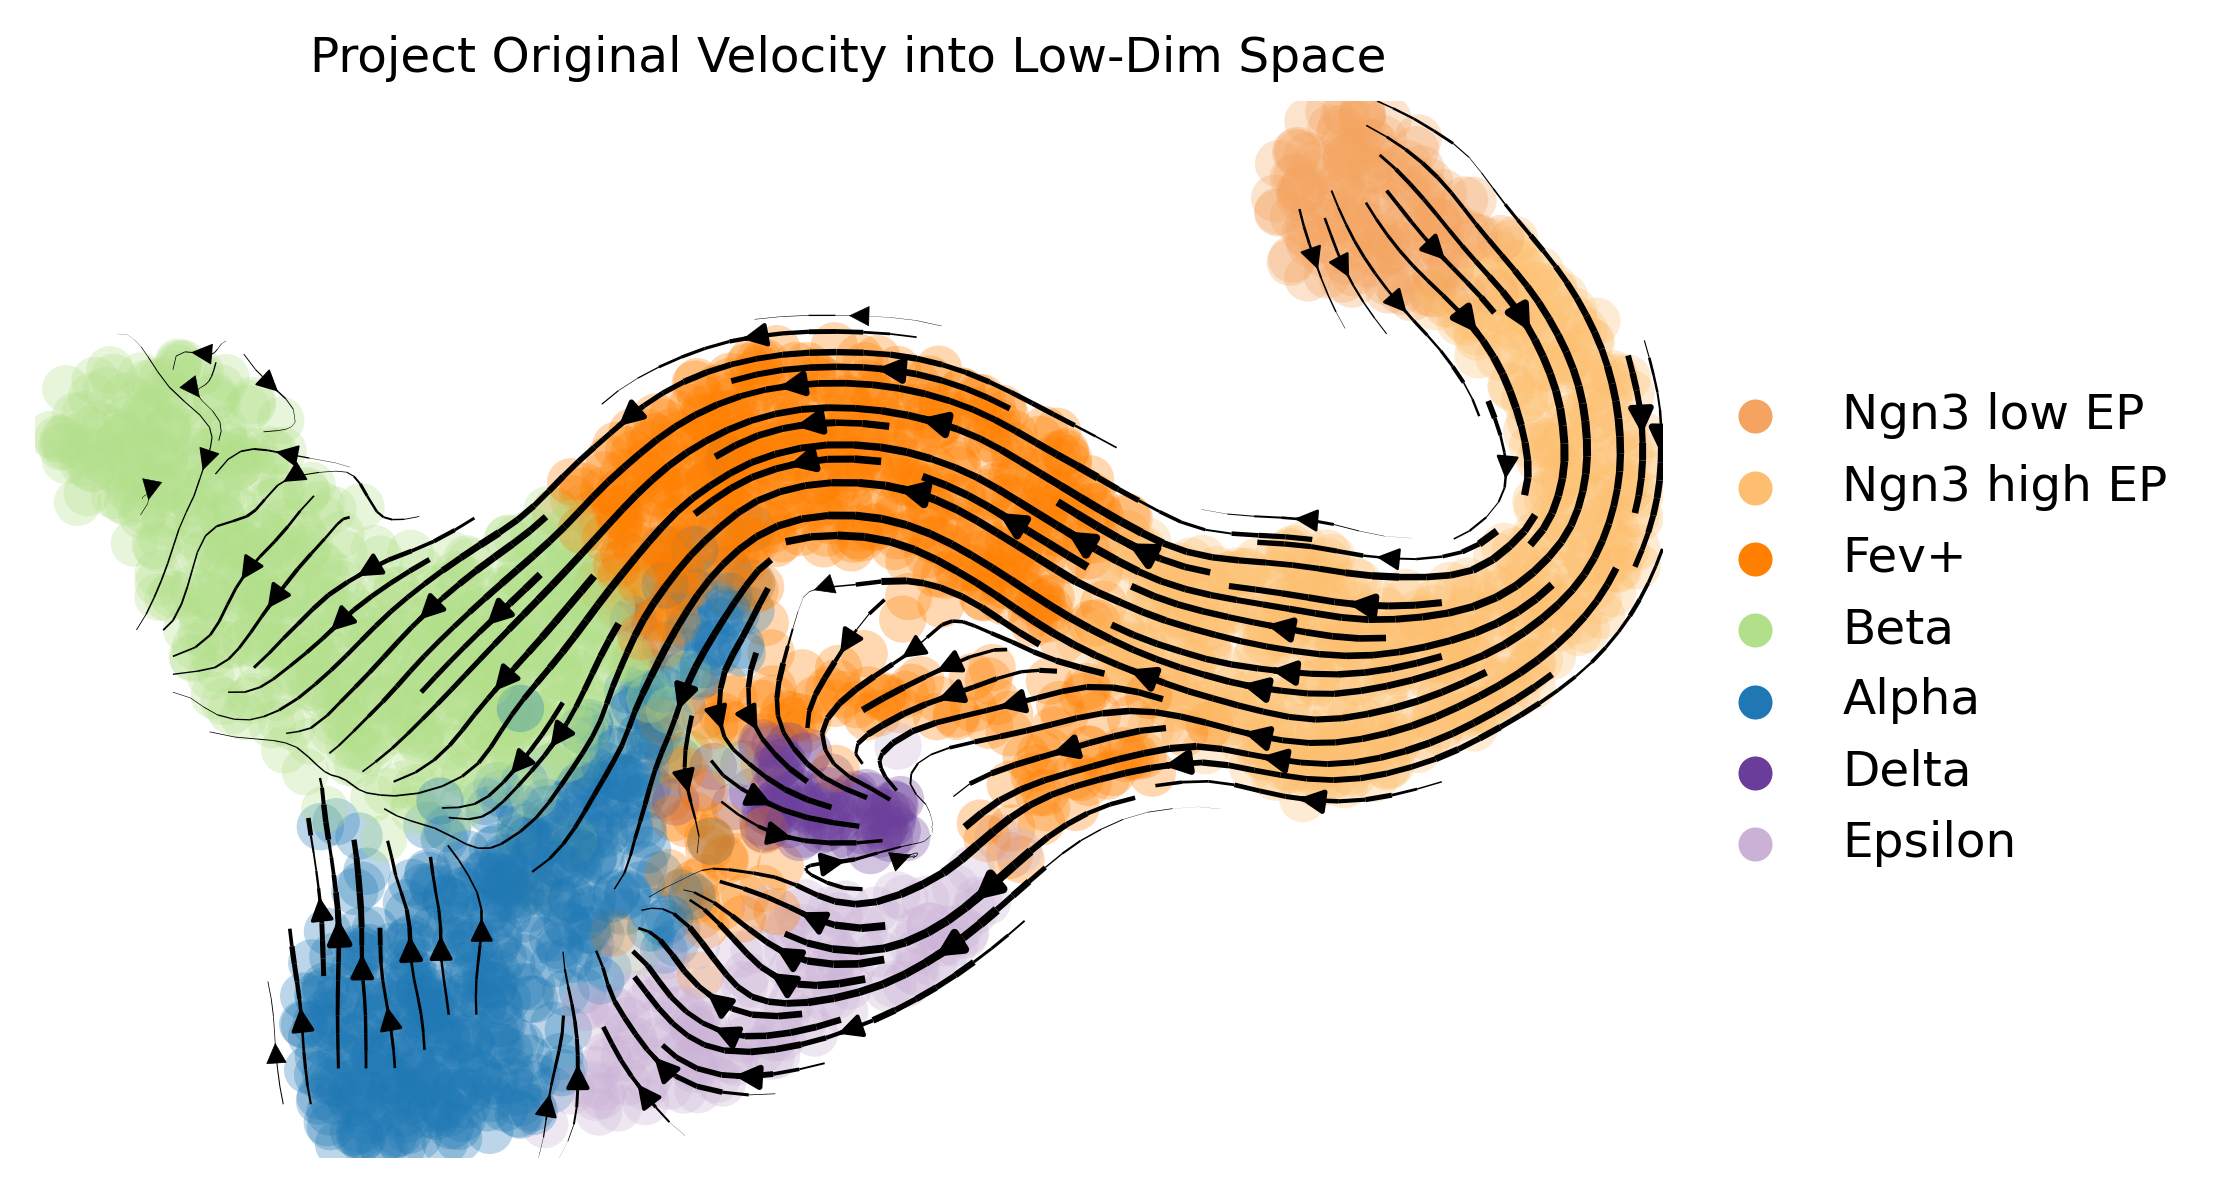

# Cross-Boundary Transition Score (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.6002964, ('Ngn3 high EP', 'Fev+'): 0.76935714, ('Fev+', 'Alpha'): 0.6994482, ('Fev+', 'Beta'): 0.73205215, ('Fev+', 'Delta'): 0.90683335, ('Fev+', 'Epsilon'): 0.37042135}
Total Mean: 0.6797347664833069
# Cross-Boundary Velocity Coherence (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.9999375, ('Ngn3 high EP', 'Fev+'): 0.9999748, ('Fev+', 'Alpha'): 0.99969333, ('Fev+', 'Beta'): 0.99964744, ('Fev+', 'Delta'): 0.99963254, ('Fev+', 'Epsilon'): 0.99953055}
Total Mean: 0.9997360110282898
# Cross-Boundary Direction Correctness (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.7799101310218552, ('Ngn3 high EP', 'Fev+'): 0.6256516925528741, ('Fev+', 'Alpha'): 0.3479450915989025, ('Fev+', 'Beta'): 0.5425404049294492, ('Fev+', 'Delta'): 0.5252163974692978, ('Fev+', 'Epsilon'): 0.0667142992236662}
Total Mean: 0.48132966946600747
# In-cluster Coherence
{'Alpha': 0.9992565, 'Beta': 0.9991297, 'Delta': 0.9999624, 'Epsilon': 0.99930996,

In [9]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=args.use_offset_pred).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.ld_nb_g_src, n_nb_newadata=args.n_nb_newadata)
    scv.tl.velocity_graph(adata, vkey='new_velocity', n_jobs=args.scv_n_jobs)
    scv.pl.velocity_embedding_stream(adata, legend_loc='right_margin', vkey="new_velocity", basis=args.vis_key, color=args.vis_type_col,
                                    title="Project Original Velocity into Low-Dim Space",
                                    dpi=350,
                                    save='pancreas_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, args.vis_type_col, "new_velocity")
    
exp(adata, exp_metrics)

Abundance of ['spliced', 'unspliced']: [0.81 0.19]


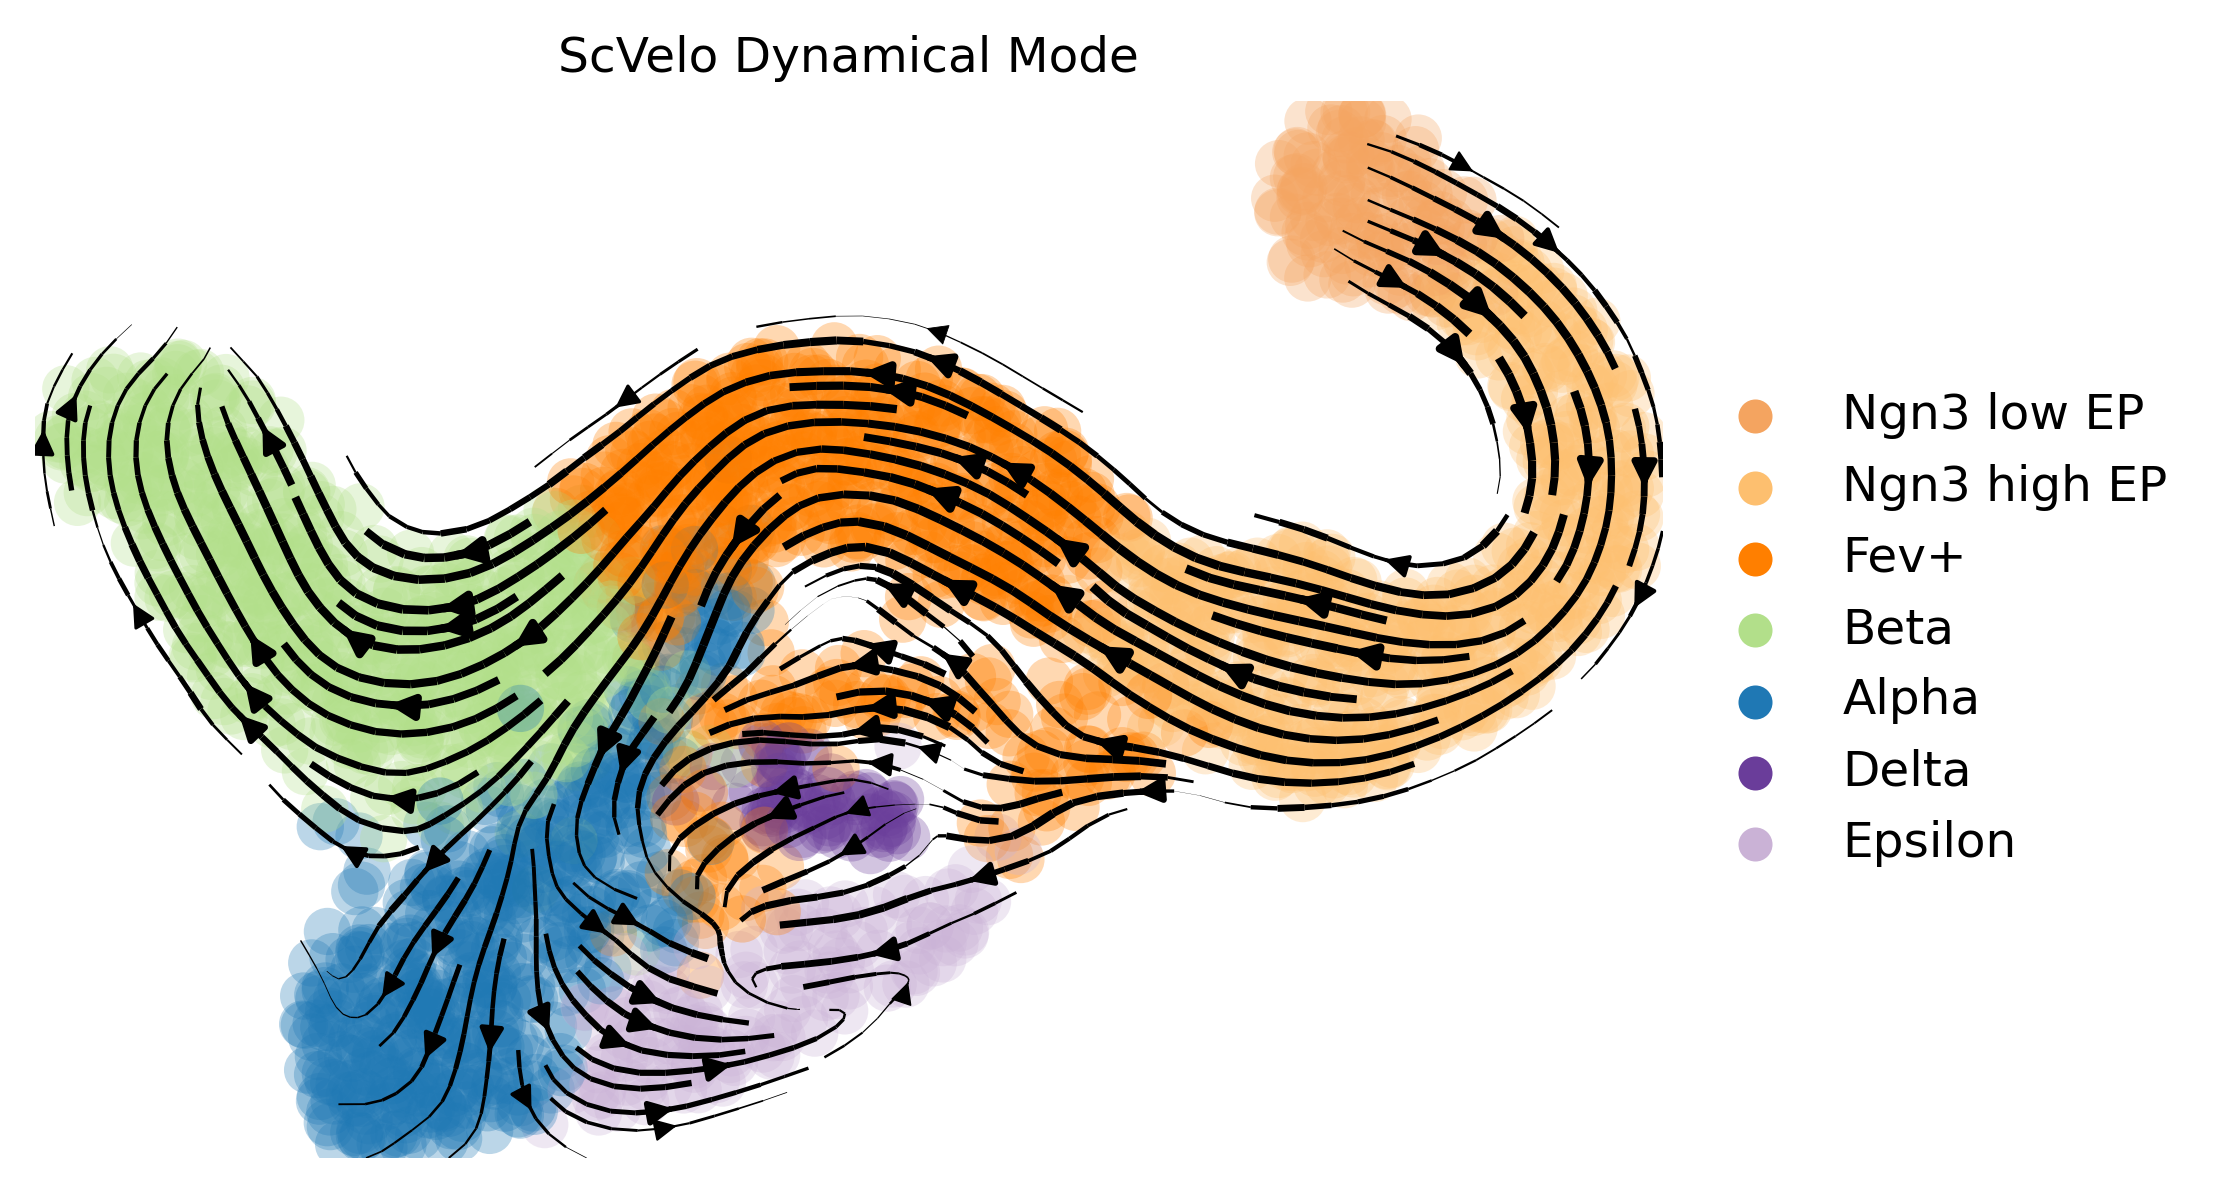

# Cross-Boundary Transition Score (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.17942013, ('Ngn3 high EP', 'Fev+'): 0.32766995, ('Fev+', 'Alpha'): 0.2567929, ('Fev+', 'Beta'): 0.26582724, ('Fev+', 'Delta'): 0.13922672, ('Fev+', 'Epsilon'): 0.20799145}
Total Mean: 0.2294880747795105
# Cross-Boundary Velocity Coherence (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.8418245230286368, ('Ngn3 high EP', 'Fev+'): 0.8296665926464104, ('Fev+', 'Alpha'): 0.8525496837457389, ('Fev+', 'Beta'): 0.8340590627468244, ('Fev+', 'Delta'): 0.859830128758387, ('Fev+', 'Epsilon'): 0.7898430396889118}
Total Mean: 0.8346288384358181
# Cross-Boundary Direction Correctness (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.8508298817471396, ('Ngn3 high EP', 'Fev+'): 0.6450989124695073, ('Fev+', 'Alpha'): 0.4306572937921889, ('Fev+', 'Beta'): 0.6921687051173799, ('Fev+', 'Delta'): -0.03908290879598821, ('Fev+', 'Epsilon'): 0.22708615645390443}
Total Mean: 0.46779300679735525
# In-cluster Coherence
{'Alpha': 0.8497277933673414,

In [10]:
adata = scanpy.read_h5ad(args.data_dir)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, n_jobs=args.scv_n_jobs)
scv.tl.velocity(adata, vkey='dyn_velocity', mode="dynamical")

scv.tl.velocity_graph(adata, vkey='dyn_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                legend_loc="right margin", 
                                vkey="dyn_velocity", 
                                basis=args.vis_key, 
                                color=[args.vis_type_col],
                                dpi=350, 
                                title='ScVelo Dynamical Mode')
exp_metrics["dyn_mode"] = evaluate(adata[:, adata.var.dyn_velocity_genes], cluster_edges, args.vis_type_col, "dyn_velocity")

In [11]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)